In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import json
import geopandas as gpd
from shapely.wkt import loads
from pyproj import Proj, Transformer

In [43]:

def lat_lon_to_axis(lat, lon, axis_direction=(1, 0), crs="EPSG:3857"):
    """
    Convert latitude and longitude to a one-dimensional value in meters along an axis.

    Args:
        lat (float): Latitude of the point.
        lon (float): Longitude of the point.
        axis_direction (tuple): Direction vector of the axis (x, y).
        crs (str): CRS for projecting to meters (default: EPSG:3857).

    Returns:
        float: One-dimensional projection value in meters.
    """
    
    # Define the transformer for projecting lat/lon to the desired CRS
    transformer = Transformer.from_crs("EPSG:4326", crs, always_xy=True)
    
    # Project the latitude and longitude to meters
    x, y = transformer.transform(lon, lat)
    
    # Normalize the axis direction vector
    axis_vector = np.array(axis_direction)
    axis_unit_vector = axis_vector / np.linalg.norm(axis_vector)
    
    # Compute the projection of the point onto the axis
    projection_value = np.dot([x, y], axis_unit_vector)
    return projection_value

def find_traffic_light_id(row, segments_gdf):
    """
    Find the nearest segment ID to a given row in a DataFrame.

    Args:
        row (pd.Series): Row in a DataFrame with columns 'lat' and 'lon'.
        segments_gdf (gpd.GeoDataFrame): GeoDataFrame with segment geometries.

    Returns:
        int: ID of the nearest segment.
    """
    # Create a GeoDataFrame for the point
    point = gpd.GeoDataFrame(
        geometry=[loads(f"POINT ({row['lat']} {row['lon']})")], crs="EPSG:4326" # Make sure lat and lon is given completely right! Lat first then lon
    )
    
    # Reproject both point and segments to a projected CRS for accurate distance calculations
    projected_crs = "EPSG:4326"  # Common projected CRS for distance calculations
    point_proj = point.to_crs(projected_crs)
    segments_gdf_proj = segments_gdf.to_crs(projected_crs)
    max_distance = float("inf")
    nearest_link_id = None
    for index, row in segments_gdf_proj.iterrows():
        distance = row.geometry.distance(point_proj.geometry[0])
        if distance < max_distance:
            max_distance = distance
            nearest_link_id = index
    return nearest_link_id


In [44]:
# loading the main dataframe
main_df = pd.read_csv("20181024_d1_0830_0900_traffic_segmented.csv")
# loading the traffic light states
with open("20181024_d1_0830_0900_traffic_light_states.json") as f:
    traffic_info = json.load(f)
# loading the segments
segments_gdf = gpd.read_file("20181024_d1_0830_0900_traffic_lights_segments.csv")
# Convert to GeoDataFrame
if "geometry" in segments_gdf.columns:
    # Convert 'geometry' to shapely objects if needed
    segments_gdf["geometry"] = segments_gdf["geometry"].apply(loads)
    # Create GeoDataFrame and set the CRS to WGS 84 (latitude/longitude)
    segments_gdf = gpd.GeoDataFrame(segments_gdf, geometry="geometry", crs="EPSG:4326")
else:
    raise ValueError("The DataFrame does not have a 'geometry' column.")

# Reproject to a projected CRS (replace EPSG code with appropriate UTM zone)
segments_gdf = segments_gdf.to_crs("EPSG:25832")  # Example for UTM Zone 32N

# Calculate lengths
segments_gdf["length"] = segments_gdf.geometry.length
segments_gdf = segments_gdf.to_crs("EPSG:4326")  # Example for UTM Zone 32N

lon_one_axis_trajectory = []
lat_one_axis_trajectory = []
for i, row in segments_gdf.iterrows():
    lat_one_axis_trajectory.append(lat_lon_to_axis(row.geometry.coords.xy[0][1], row.geometry.coords.xy[0][0], crs="EPSG:4326"))
    lon_one_axis_trajectory.append(lat_lon_to_axis(row.geometry.coords.xy[1][1], row.geometry.coords.xy[1][0], crs="EPSG:4326"))

segments_gdf["lon_one_axis_trajectory"] = lon_one_axis_trajectory
segments_gdf["lat_one_axis_trajectory"] = lat_one_axis_trajectory

# Calculate total length
total_length = segments_gdf["length"].sum()

# loading the traffic lights
traffic_lights_df = pd.read_csv("traffic_lights.csv")
# find traffic light segment id
traffic_lights_df["nearest_link_id"] = traffic_lights_df.apply(find_traffic_light_id, axis=1, segments_gdf=segments_gdf)
traffic_lights_df = traffic_lights_df.iloc[:5, :]
# loading the traffic light states
with open("traffic_info_dict.pkl", "rb") as f:
    traffic_lights_dict_states = pickle.load(f)


In [46]:
# Read the CSV file
main_df_truncated_with_cell = pd.read_csv("20181024_d1_0830_0900_segmented_oneaxistrajectory_cell_main.csv")

# Group by the desired columns and aggregate the vehicle IDs into a frozenset
grouped_with_veh_ids = main_df_truncated_with_cell.groupby(["link_id", "time"]).agg({
    "veh_id": lambda x: frozenset(x)  # Use frozenset instead of set
}).reset_index()

# Merge the new column back into the original dataframe
main_df_truncated_with_cell = main_df_truncated_with_cell.merge(grouped_with_veh_ids, on=["link_id", "time"], suffixes=('', '_list'))

# Rename the new column for clarity
main_df_truncated_with_cell.rename(columns={"veh_id_list": "veh_id_list"}, inplace=True)

# Display the shapes
duplicate_dropped = main_df_truncated_with_cell.drop_duplicates(subset=["link_id", "time", "veh_id_list"])[["veh_id_list", "link_id", "time"]]


link_dataframes = {}
duplicate_dropped.columns = [f"{col}_{i}" if duplicate_dropped.columns.duplicated()[i] else col for i, col in enumerate(duplicate_dropped.columns)]
for link_id in duplicate_dropped["link_id"].unique():
    
    
    segment_df = duplicate_dropped[duplicate_dropped["link_id"] == link_id].reset_index().drop(columns=["index"])
    segment_df = segment_df.sort_values("time")

    segment_df["N_down"] = segment_df["veh_id_list"] - segment_df["veh_id_list"].shift(1)
    segment_df["N_up"] = segment_df["veh_id_list"].shift(-1) - segment_df["veh_id_list"] 

    segment_df["N_cumsum_down"] = segment_df["N_down"].iloc[1:].apply(len).cumsum()
    segment_df["N_cumsum_up"] = segment_df["N_up"].iloc[:-1].apply(len).cumsum()
    
    link_dataframes[link_id] = segment_df


In [5]:
import math
def cumulativecount_up(time, link_id):
    segment_df = link_dataframes[link_id]
    closest_time = segment_df[segment_df['time'] <= time].time.max()
    if math.isnan(closest_time):
        return 0
    return segment_df[segment_df['time'] == closest_time]["N_cumsum_up"].values[0]

def cumulativecount_down(time, link_id):
    segment_df = link_dataframes[link_id]
    closest_time = segment_df[segment_df['time'] <= time].time.max()
    if math.isnan(closest_time):
        return 0
    return segment_df[segment_df['time'] == closest_time]["N_cumsum_down"].values[0]

In [47]:
from constants import CTMParameters
from helper import *
import math

# Notes for Maziar:
## Do not use CTMParameters().object at all! If you use it, it will create a new object every time you call it. Instead, use the instance that you make of it!
## Try avoidng using the istance of CTMParemeters as a global object. Instead, pass it as an argument to the functions that need it.
## The docstring could be formatted for clarity: 1- Mention all parameters and their expected types! 2- Include an explanation of the function's output!
## Check for invalid or empty densities.
## Use descriptive variable names for better readability.
## Avoid magic numbers like 1 for the green light status; use constants instead.


# load params
ctm_params = CTMParameters() # for now, we use same parameters we had in CTM model
ctm_params.segment_length = segments_gdf["length"].mean()
# define the function for finding cumulative counts
N_upstr = cumulativecount_up
N_downstr = cumulativecount_down

## Cell transmission model: update cell density
# time: current simulation time
# arguments: N_upstrs: cumulative count of vehicles in upstream at a given time. I'll pass N_downstr(t) and it should tell me the cumulative count
# N_downstr: cumulative count at link downstream at time t (current time)
# entry_flow: for now constant, entering to the link in vehicles per second
# assumptions: jam density and max flow are constant for all cells
def update_point_queue(time, link_id, entry_flow, traffic_lights_df, traffic_lights_dict_states):

    # check if there is a traffic light at the end of the segment
    if is_tl(link_id, traffic_lights_df):
        # check the status of the traffic light
        if tl_status(time, link_id, traffic_lights_df, traffic_lights_dict_states) == 1: # green light
            # find the link sending flow using point queue model 
            sending_flow = min( N_upstr(time + ctm_params.time_step - (ctm_params.segment_length/ctm_params.free_flow_speed), link_id) - N_downstr(time , link_id), ctm_params.max_flow()*ctm_params.time_step)
        else:
            sending_flow = 0
    else: # no traffic light at the end of the link
        sending_flow = min( N_upstr(time + ctm_params.time_step - (ctm_params.segment_length/ctm_params.free_flow_speed), link_id) - N_downstr(time , link_id), ctm_params.max_flow()*ctm_params.time_step)

    # find the number of vehicles in the link at the next time step
    n_current =  N_upstr(time, link_id) - N_downstr(time, link_id)   # current number of vehicles
    
    n_updated = n_current + entry_flow * ctm_params.time_step -  sending_flow 
    if n_updated < 0:
        print("n_current", n_current, "sending flow", sending_flow, "entry flow", entry_flow, "time", time)
        print("N DOWNSTR is", N_upstr(time, link_id)  ,"at this time N special is", N_upstr(time + ctm_params.time_step - (ctm_params.segment_length/ctm_params.free_flow_speed), link_id)) 

    link_outflow = sending_flow
    link_density = n_updated / ctm_params.segment_length
    return link_density, link_outflow    # please note the   order ## I will:)


# Get inflow

In [48]:
inflow = pd.read_csv("20181024_d1_0830_0900_inflow.csv")

# Running the model

In [49]:
from collections import defaultdict

point_queue_data = defaultdict(dict)

for link_id in duplicate_dropped["link_id"].unique():
    segment_df = duplicate_dropped[duplicate_dropped["link_id"] == link_id].reset_index().drop(columns=["index"])
    segment_df = segment_df.sort_values("time")
    for time in segment_df["time"].unique():
            
        entry_flow = inflow[(inflow["link_id"] == link_id) & (inflow["time"] == time)]["inflow"]
        if entry_flow.empty:
            entry_flow = 0
        else:
            entry_flow = entry_flow.values[0]
        
        link_density, link_outflow = update_point_queue(time, link_id, entry_flow, traffic_lights_df, traffic_lights_dict_states)
        
        point_queue_data[link_id][time] = {"link_density": link_density, "link_outflow": link_outflow}
        # print(time, link_id, "done")
        

In [50]:
import pickle

with open("20181024_d1_0830_0900_result_point_queue.pkl", "wb") as f:
    pickle.dump(point_queue_data, f)


point_queue_data = pickle.load(open("20181024_d1_0830_0900_result_point_queue.pkl", "rb"))


In [52]:
duplicate_dropped["no_veh"] = duplicate_dropped["veh_id_list"].apply(len)
duplicate_dropped["density"] = duplicate_dropped["no_veh"] / ctm_params.segment_length
duplicate_dropped

,veh_id_list,link_id,time,no_veh,density
0,"(1, 59, 60, 84)",4,0.00,4,0.034735
1,"(1, 59, 60, 84)",4,0.04,4,0.034735
2,"(1, 59, 60, 84)",4,0.08,4,0.034735
3,"(1, 59, 60, 84)",4,0.12,4,0.034735
4,"(1, 59, 60, 84)",4,0.16,4,0.034735
...,...,...,...,...,...
694918,"(899, 903, 904, 906, 908, 909, 911, 913, 914, ...",0,818.64,12,0.104205
694919,"(899, 903, 904, 906, 908, 909, 911, 913, 914, ...",0,818.68,12,0.104205
694920,"(899, 903, 904, 906, 908, 909, 911, 913, 914, ...",0,818.72,12,0.104205
694921,"(899, 903, 904, 906, 908, 909, 911, 913, 914, ...",0,818.76,12,0.104205


# Checking the point queue model

In [53]:
duplicate_dropped["predicted_density"] = duplicate_dropped.apply(lambda x: point_queue_data[x["link_id"]][x["time"]]["link_density"], axis=1).fillna(0)
duplicate_dropped

,veh_id_list,link_id,time,no_veh,density,predicted_density
0,"(1, 59, 60, 84)",4,0.00,4,0.034735,0.000000
1,"(1, 59, 60, 84)",4,0.04,4,0.034735,0.000000
2,"(1, 59, 60, 84)",4,0.08,4,0.034735,0.000000
3,"(1, 59, 60, 84)",4,0.12,4,0.034735,0.000000
4,"(1, 59, 60, 84)",4,0.16,4,0.034735,0.000000
...,...,...,...,...,...,...
694918,"(899, 903, 904, 906, 908, 909, 911, 913, 914, ...",0,818.64,12,0.104205,0.078154
694919,"(899, 903, 904, 906, 908, 909, 911, 913, 914, ...",0,818.68,12,0.104205,0.078154
694920,"(899, 903, 904, 906, 908, 909, 911, 913, 914, ...",0,818.72,12,0.104205,0.078154
694921,"(899, 903, 904, 906, 908, 909, 911, 913, 914, ...",0,818.76,12,0.104205,0.078154


# RMSE for each link

In [54]:
for link_id in sorted(duplicate_dropped["link_id"].unique()):
    rmse = np.sqrt(np.mean((duplicate_dropped[duplicate_dropped["link_id"] == link_id]["density"] - duplicate_dropped[duplicate_dropped["link_id"] == link_id]["predicted_density"])**2))
    print("For link with id: ", link_id, " the RMSE is: ", rmse)

For link with id:  0  the RMSE is:  0.04017608867221792
For link with id:  1  the RMSE is:  0.030006903120207887
For link with id:  2  the RMSE is:  0.06638150905753384
For link with id:  3  the RMSE is:  0.05941726992117481
For link with id:  4  the RMSE is:  0.032348968689404824


/var/folders/08/xlt8ht5x04x0hg_fhxdwdl7m0000gr/T/ipykernel_56634/3001758016.py:4: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/08/xlt8ht5x04x0hg_fhxdwdl7m0000gr/T/ipykernel_56634/3001758016.py:8: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



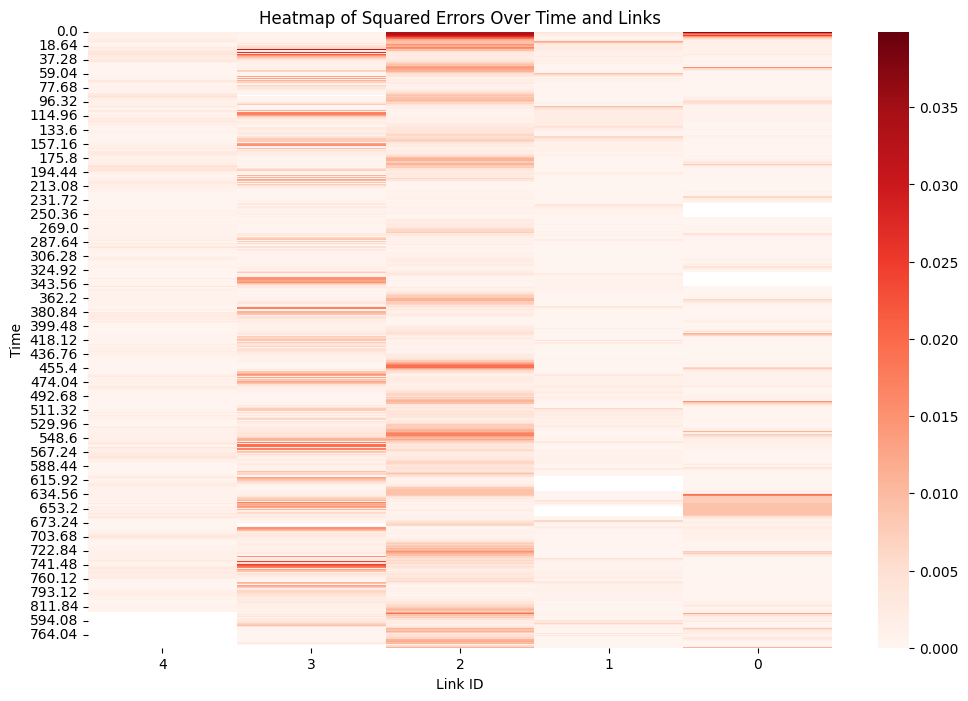

In [55]:
import seaborn as sns

duplicate_dropped["e2"] = (duplicate_dropped["density"] - duplicate_dropped["predicted_density"])**2
duplicate_dropped.groupby("time").apply(lambda x: x.set_index("link_id")["e2"].to_dict()).to_dict()
import matplotlib.pyplot as plt

# Convert the dictionary to a DataFrame for easier plotting
heatmap_df = pd.DataFrame.from_dict(duplicate_dropped.groupby("time").apply(lambda x: x.set_index("link_id")["e2"].to_dict()).to_dict(), orient='index')
heatmap_df.index.name = 'time'

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_df, cmap="Reds", annot=False)
plt.title("Heatmap of Squared Errors Over Time and Links")
plt.xlabel("Link ID")
plt.ylabel("Time")
plt.show()

## Interactive plot

In [56]:
import plotly.express as px

threshold = heatmap_df.shape[0]
data = heatmap_df.values[:threshold]

# Fixed figure size
fig_width = 1200
fig_height = 800

# Create the heatmap
fig = px.imshow(
    data,
    labels=dict(x="Link ID", y="Time", color="Squared Error"),
    x=[str(i) for i in range(data.shape[1])],  
    y=[heatmap_df.index[i] for i in range(threshold)],
    color_continuous_scale="Viridis"
)

fig.update_layout(
    title="Fixed Size Interactive Heatmap",
    xaxis=dict(scaleanchor="x", constrain="domain"),
    yaxis=dict(scaleanchor="y", constrain="domain"),
    width=fig_width,
    height=fig_height
)

fig.show()


In [40]:
heatmap_df.index

Index([360.72, 360.76,  360.8, 360.84, 360.88, 360.92, 360.96,  361.0, 361.04,
       361.08,
       ...
       440.32, 440.36,  440.4, 440.44, 440.48, 440.52, 440.56,  440.6, 440.64,
       440.68],
      dtype='float64', name='time', length=2000)